# A TUTORIAL ON K-MEANS CLUSTERING

by Sebastian T. Glavind, October, 2022

In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In this tutorial, we will consider how to use the K-means algorithm to find latent clusters in a data set. Thus, we will learn a cluster representation for a fixed number of clusters, and we will show how to pick the optimal number of clusters, see e.g. Murphy (2022; Sec. 21.3) for a reference on K-means algorithm.

***
Murphy, Kevin P. Probabilistic machine learning: an introduction. MIT press, 2022.
***

## Sample data

### True model parameters

In [2]:
# Define parameters for 3 clusters
mu_mix = np.array([ [10,3],[1,1], [5,4] ]) # mean
Sig_mix = np.array([ [[1,0],[0,1]],[[1.5,0],[0,1.5]],[[2,0],[0,2]] ]) # covariance

### Generate data

In [3]:
np.random.seed(10)

nX_i = 100 # data points pr. cluster
X3d = np.zeros((3,nX_i,2))
for i in range(3): 
    X3d[i,:,:] = np.random.multivariate_normal(mu_mix[i,:], Sig_mix[i], nX_i)
    
X = X3d.reshape(3*nX_i,2)
nX, mX = X.shape

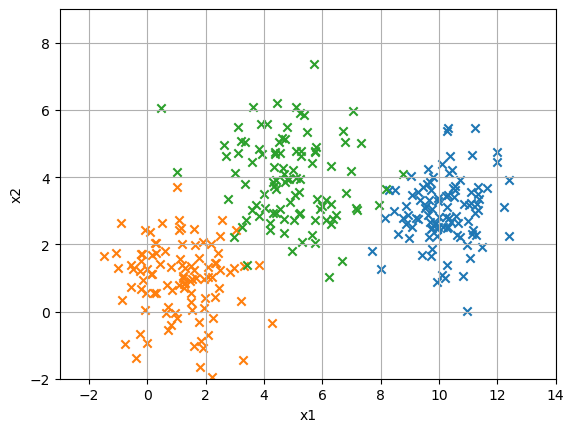

In [4]:
colors = sns.color_palette(n_colors=6)
def plot_data(X3d, colors=colors):
    plt.scatter(X3d[0,:,0], X3d[0,:,1], marker='x', color=colors[0]);
    plt.scatter(X3d[1,:,0], X3d[1,:,1], marker='x', color=colors[1]);
    plt.scatter(X3d[2,:,0], X3d[2,:,1], marker='x', color=colors[2]);
    plt.xlim([-3,14])
    plt.ylim([-2,9])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid()

plot_data(X3d)
plt.show()

## K-means algorithm

Based on Murphy (2022), Sec. 21.3.

### Helper functions

In [5]:
# From https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning?
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (N,M) Input values      
        centroids (ndarray): k centroids
    
    Returns:
        idx (array_like): (N,) closest centroids
    
    """

    K = centroids.shape[0]  # Set K
    idx = np.zeros(X.shape[0], dtype=int) # cluster assignment

    for i in range(X.shape[0]):
        distance = [] # Array to hold distance between X[i] and each centroids[j]
        for j in range(centroids.shape[0]):
            norm_ij = np.linalg.norm(X[i] - centroids[j]) # norm between (X[i] - centroids[j])
            distance.append(norm_ij)

        idx[i] = np.argmin(distance)# index of minimum value in distance
    
    return idx

# From https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning?
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (N,M) Data points
        idx (ndarray): (N,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, M) New centroids computed
    """
    
    # Useful variables
    N,M = X.shape
    
    centroids = np.zeros((K, M))
    for k in range(K):   
        points = X[idx == k] # list of all data points in X assigned to centroid k  
        centroids[k] = np.mean(points, axis = 0) # compute the mean of the points assigned
    
    return centroids

# From https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning?
def myKmeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    N,M = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids.copy()
    previous_centroids = centroids    
    idx = np.zeros(N)
    
    # Run K-means
    for i in range(max_iters):
        print("K-means iteration %d/%d" % (i, max_iters-1)) #Output progress
        idx = find_closest_centroids(X, centroids)  # For each example in X, assign it to the closest centroid
        centroids = compute_centroids(X, idx, K) # Given the memberships, compute new centroids
    plt.show() 
    return centroids, idx

In [6]:
np.random.seed(42)

initial_centroids = X[np.random.choice(np.arange(0,nX,1), 3, replace=False),:] # Set initial centroids to random points in the training set
max_iters = 10 # Number of iterations
centroids, idx = myKmeans(X, initial_centroids, max_iters, plot_progress=False)

K-means iteration 0/9
K-means iteration 1/9
K-means iteration 2/9
K-means iteration 3/9
K-means iteration 4/9
K-means iteration 5/9
K-means iteration 6/9
K-means iteration 7/9
K-means iteration 8/9
K-means iteration 9/9


In [7]:
centroids

array([[10.11208937,  3.00104327],
       [ 4.84951456,  3.93224346],
       [ 1.11914672,  0.97265406]])

### Plot resulting model

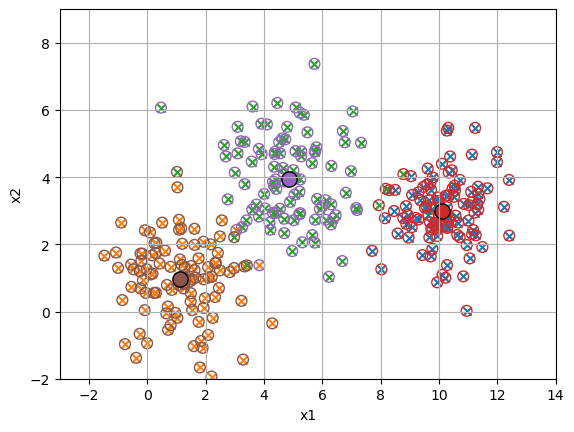

In [8]:
# Plotting
def plot_dataAndModel(X3d, centroids, idx):
    plot_data(X3d)
    for i in range(centroids.shape[0]):
        # plt.plot(*centroids[i,:], marker='o', color=colors[3+i], markersize=10)
        plt.scatter(X[idx==i,0], X[idx==i,1], s=60, facecolors='none', edgecolors=colors[3+i])
        plt.scatter(*centroids[i,:], s=120, facecolors=colors[3+i], edgecolors='black')
plot_dataAndModel(X3d, centroids, idx)
plt.show()

This looks pretty good.

### Test against scikit-learn implementation

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [9]:
# load scikit
import os
os.environ["OMP_NUM_THREADS"] = '2' # needed due to memory leak in the scikit implementation
from sklearn.cluster import KMeans

# Fit scikit model
mdl = KMeans(n_clusters=3, n_init=10, random_state=42) # it is recommended to run the algo. multiple times
mdl.fit(X);

In [10]:
mdl.cluster_centers_

array([[10.11208937,  3.00104327],
       [ 1.16431528,  0.99069285],
       [ 4.87939088,  3.97544754]])

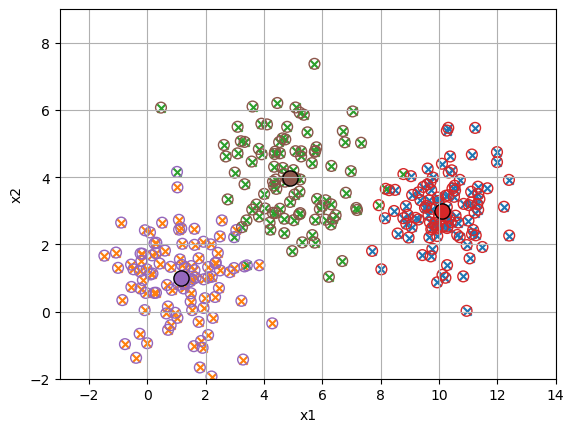

In [11]:
# Plotting
plot_dataAndModel(X3d, mdl.cluster_centers_, mdl.labels_)
plt.show()

This looks like what we found above.

### Model selection

Generally, the choice of the number of clusters is ambiguous – I may see 2 while you see 4 – thus ideally, the number of clusters should be chosen based on the downstream purpose of the clustering and potential costs/benefits associated with different choices. However, the elbow method shown below may give some guidance as to a reasonable range of clusters.  

#### Model selection using elbow method

In [12]:
def costFunk(X, centroids, idx):
    """
    Computes the (distortion) cost function
    
    Args:
        X (ndarray): (N,M) Input values      
        centroids (ndarray): k centroids
        idx (array_like): (N,) closest centroids
    Returns:
        cost (scalar): the cost over all examples
    """
    N = X.shape[0]
    K = centroids.shape[0]  # Set K
    cost_sum = 0.
    for k in range(centroids.shape[0]):
        cost_sum += np.sum(np.linalg.norm(X[idx==k] - centroids[k,:], axis=1)**2) # cost of examples in cluster i
    cost = cost_sum/N
    
    return cost

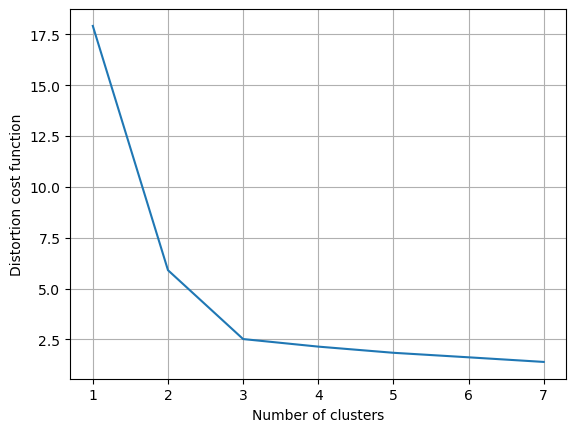

In [13]:
Cs = range(1, 8)
costs = []

for C in Cs:
    mdl_c = KMeans(n_clusters=C, n_init=10) # it is recommended to run the algo. multiple times
    mdl_c.fit(X)
    cost_c = costFunk(X=X, centroids=mdl_c.cluster_centers_, idx=mdl_c.labels_)
    costs.append(cost_c)
    
plt.plot(Cs, costs)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion cost function')
plt.grid();

Note that the curve flattens at 3 components.